# data3a - Damage Severity

In [ ]:
import urllib.request
import pickle
import matplotlib.pyplot as plt
from IPython.display import display,Image,clear_output
import numpy as np
import os
import h5py
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report,confusion_matrix
from collections import Counter,defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Dropout, Activation, add
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.utils import to_categorical
from keras.utils import get_file
from keras import optimizers
from keras.regularizers import l1, l2
from keras.callbacks import ModelCheckpoint, History

In [ ]:
from keras import backend as K
K.backend()

'tensorflow'

In [ ]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('vgg16_weights.h5', WEIGHTS_PATH_NO_TOP)

58889256/58889256 [==============================] - 1s 0us/step


### Defining input data

In [ ]:
# path to the model weights file
location = '/content/drive/My Drive/TVS/car-damage-dataset/data3a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
fine_tuned_model_path = '/content/drive/My Drive/TVS/car-damage-dataset/data3a/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
val_data_dir = location+'/validation'

train_samples = [len(os.listdir(os.path.join(train_data_dir,i))) for i in os.listdir(train_data_dir)]
nb_train_samples = sum(train_samples)
val_samples = [len(os.listdir(os.path.join(val_data_dir,i))) for i in os.listdir(val_data_dir)]
nb_val_samples = sum(val_samples)

nb_epoch = 50

In [ ]:
train_samples

[386, 315, 278]

In [ ]:
K.image_data_format()

'channels_last'

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3,img_height,img_widthdth)
else:
    input_shape = (img_height,img_width,3)

In [ ]:
input_shape

(256, 256, 3)

In [ ]:
# def load_vgg16(weights_path='../vgg16_weights.h5'):
#     model = Sequential()
#     model.add(ZeroPadding2D(padding=(1,1),input_shape=(224,224,3)))

#     model.add(Convolution2D(filters=64, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=64, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=128, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=128, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))





In [ ]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=input_shape ,pooling=max)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# Set base_model layers to non-trainable
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
def preprocess_input_vgg(x):
    """
    x : a numpy 3darray (a single image to be preprocessed)

    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.

    Returns a numpy 3darray (the preprocessed image).
"""
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [ ]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

    if(os.path.exists(location+'/bottleneck_features_train.npy')):
        print('Already exists',location+'/bottleneck_features_train.npy')
    else:
        train_generator = datagen.flow_from_directory(train_data_dir,
                                                      target_size=(img_height,img_width),
                                                      batch_size=16,
                                                      class_mode=None,
                                                      shuffle=False)

        bottleneck_features_train = base_model.predict_generator(train_generator,
                                                                 nb_train_samples / 16,
                                                                 verbose=1)

        print('Saving',location+'/bottleneck_features_train.npy')
        np.save(open(location+'/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
        #np.save(location+'/bottleneck_features_train.npy',bottleneck_features_train)

    if(os.path.exists(location+'/bottleneck_features_val.npy')):
        print('Already exists',location+'/bottleneck_features_val.npy')
    else:
        # Repeat it with validation data
        val_generator = datagen.flow_from_directory(val_data_dir,
                                                    target_size=(img_height,img_width),
                                                    batch_size=16,
                                                    class_mode=None,
                                                    shuffle=False)

        bottleneck_features_val = base_model.predict_generator(val_generator,
                                                               nb_val_samples / 16,
                                                               verbose=1)
        print('Saving',location+'/bottleneck_features_val.npy')
        np.save(open(location+'/bottleneck_features_val.npy','wb'),bottleneck_features_val)


In [ ]:
# load saved data and train a small, fully-connected ModelCheckpoint
def train_categorical_model(location):
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(open(location+'/bottleneck_features_train.npy', 'rb'))
    print(train_data.shape[1:])
    train_labels = np.array([0]*train_samples[0]
                            +[1]*train_samples[1]
                            +[2]*train_samples[2])

    train_labels = to_categorical(train_labels)

    val_data = np.load(open(location+'/bottleneck_features_val.npy','rb'))
    val_labels = np.array([0]*val_samples[0]
                          +[1]*val_samples[1]
                          +[2]*val_samples[2])

    val_labels = to_categorical(val_labels)

    model = Sequential()
    model.add(Flatten(input_shape=(train_data.shape[1:])))     # 8, 8, 512
    model.add(Dense(units=256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=3,activation='softmax'))             # upped to 3 so activation softmax

    model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),
                  loss='categorical_crossentropy',
                 metrics = ['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True,mode='auto')     # ?read documentation

    fit = model.fit(train_data,train_labels,
                    #epochs=nb_epoch,
                    epochs=60,
                    batch_size=16,
                    validation_data=(val_data,val_labels),
                    callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
val_data = np.load(open(location+'/bottleneck_features_val.npy','rb'))
val_data.shape

(171, 8, 8, 512)

In [ ]:
def finetune_categorical_model(location):
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(units=256,activation='relu'))
    top_model.add(Dropout(rate=0.5))
    top_model.add(Dense(units=3,activation='softmax'))

    top_model.load_weights(top_model_weights_path)



    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))


    model.compile(optimizer=optimizers.SGD(lr=0.00001,momentum=0.9),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=8,
                                                        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(val_data_dir,
                                                      target_size=(img_height, img_width),
                                                      batch_size=8,
                                                      class_mode='categorical',
                                                      shuffle=False)
    checkpoint = ModelCheckpoint(filepath=fine_tuned_model_path,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto')

    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples/8,
                              epochs=10,
                              validation_data=test_generator,
                              validation_steps=nb_val_samples/8,
                              verbose=1,
                              callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
def evaluate_categorical_model(model,directory,labels,Force=False):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

    if(os.path.exists(location+'/pred_labels.npy')) and not Force:
        print('Already exists',location+'/pred_labels.npy')
        pred_labels = np.load(open(location+'/pred_labels.npy', 'rb'))
    else:
        # Repeat it with validation data
        test_generator = test_datagen.flow_from_directory(directory,
                                                     target_size=(img_height,img_width),
                                                     batch_size=8,
                                                     class_mode='categorical',     # categorical for multiclass
                                                     shuffle=False)

        predictions = model.predict_generator(test_generator,
                                              steps=len(labels)/8,
                                              verbose=1)

        # use for multiclass
        pred_labels = np.argmax(predictions, axis=1)

        # pred_labels = [0 if i <0.5 else 1 for i in predictions]
        print('Saving',location+'/pred_labels.npy')
        np.save(open(location+'/pred_labels.npy','wb'),pred_labels)
        #np.save(location+'/bottleneck_features_val.npy',bottleneck_features_train)

    print()
    print(classification_report(labels, pred_labels))
    print()
    cm = confusion_matrix(labels, pred_labels)
#     sns.heatmap(cm, annot=True, fmt='g');
    return cm

In [ ]:
def plot_metrics(hist, stop=50):  # stop -> no of data pts in plot
                                # hist(history) -> dict
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    # axes = axes.flatten()   # flatten -> numpy flatten

    ax0.plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    ax0.plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    ax0.set_title('Accuracy')
    ax0.set_ylabel('Accuracy')
    ax0.set_xlabel('Epoch')
    ax0.legend(loc='lower right')

    ax1.plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    ax1.plot(range(stop), hist['val_loss'],label='Validation', color='#03507E')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    plt.tight_layout()

    print("Best Model: ")
    print_best_model_results(hist)

In [ ]:
def view_images(img_dir,img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1,', val_acc:', model_hist['val_acc'][best_epoch],', val_loss:',
          model_hist['val_loss'][best_epoch])

### Training

In [ ]:
# do not rerun!!
save_bottleneck_features(location)

Already exists /content/drive/My Drive/TVS/car-damage-dataset/data3a/bottleneck_features_train.npy
Already exists /content/drive/My Drive/TVS/car-damage-dataset/data3a/bottleneck_features_val.npy


In [ ]:
sns.set_style('whitegrid')

In [ ]:
d3a_model1,d3a_history1 = train_categorical_model(location)    # With regularization

(8, 8, 512)
Epoch 1/60
57/62 [==========================>...] - ETA: 0s - loss: 484.7715 - accuracy: 0.3728

62/62 [==============================] - 6s 12ms/step - loss: 451.6687 - accuracy: 0.3810 - val_loss: 6.8140 - val_accuracy: 0.3275
Epoch 2/60
58/62 [===========================>..] - ETA: 0s - loss: 962.9094 - accuracy: 0.3858 

62/62 [==============================] - 0s 7ms/step - loss: 912.8019 - accuracy: 0.3933 - val_loss: 1.0957 - val_accuracy: 0.3275
Epoch 3/60
56/62 [==========================>...] - ETA: 0s - loss: 494.8687 - accuracy: 0.3895

62/62 [==============================] - 0s 6ms/step - loss: 453.0045 - accuracy: 0.3943 - val_loss: 1.1080 - val_accuracy: 0.3216
Epoch 4/60
53/62 [========================>.....] - ETA: 0s - loss: 678.1555 - accuracy: 0.3998

62/62 [==============================] - 0s 6ms/step - loss: 592.6297 - accuracy: 0.3933 - val_loss: 1.1044 - val_accuracy: 0.3216
Epoch 5/60
55/62 [=========================>....] - ETA: 0s - loss: 31.9428 - accuracy: 0.3955

62/62 [==============================] - 0s 6ms/step - loss: 28.8239 - accuracy: 0.3984 - val_loss: 1.1022 - val_accuracy: 0.3216
Epoch 6/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0780 - accuracy: 0.3962

62/62 [==============================] - 0s 5ms/step - loss: 557.0065 - accuracy: 0.4014 - val_loss: 1.1052 - val_accuracy: 0.3216
Epoch 7/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0738 - accuracy: 0.3994

62/62 [==============================] - 0s 6ms/step - loss: 1.0726 - accuracy: 0.4025 - val_loss: 1.1045 - val_accuracy: 0.3216
Epoch 8/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0710 - accuracy: 0.4068

62/62 [==============================] - 0s 6ms/step - loss: 1.0732 - accuracy: 0.4025 - val_loss: 1.1015 - val_accuracy: 0.3216
Epoch 9/60
53/62 [========================>.....] - ETA: 0s - loss: 1.3720 - accuracy: 0.4033

62/62 [==============================] - 0s 6ms/step - loss: 1.3348 - accuracy: 0.3994 - val_loss: 1.1056 - val_accuracy: 0.3216
Epoch 10/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0801 - accuracy: 0.3944

62/62 [==============================] - 0s 5ms/step - loss: 1.0789 - accuracy: 0.3994 - val_loss: 1.1010 - val_accuracy: 0.3216
Epoch 11/60
58/62 [===========================>..] - ETA: 0s - loss: 1.6249 - accuracy: 0.3955

62/62 [==============================] - 0s 6ms/step - loss: 1.5958 - accuracy: 0.3984 - val_loss: 1.1059 - val_accuracy: 0.3216
Epoch 12/60
61/62 [============================>.] - ETA: 0s - loss: 1.0818 - accuracy: 0.3975

62/62 [==============================] - 0s 5ms/step - loss: 1.0816 - accuracy: 0.3984 - val_loss: 1.0978 - val_accuracy: 0.3216
Epoch 13/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0742 - accuracy: 0.4051

62/62 [==============================] - 0s 6ms/step - loss: 1.0773 - accuracy: 0.3994 - val_loss: 1.1021 - val_accuracy: 0.3216
Epoch 14/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0778 - accuracy: 0.4002

62/62 [==============================] - 0s 6ms/step - loss: 1.0786 - accuracy: 0.3973 - val_loss: 1.1029 - val_accuracy: 0.3216
Epoch 15/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0783 - accuracy: 0.3955

62/62 [==============================] - 0s 6ms/step - loss: 1.0768 - accuracy: 0.3984 - val_loss: 1.1012 - val_accuracy: 0.3216
Epoch 16/60
55/62 [=========================>....] - ETA: 0s - loss: 1.1247 - accuracy: 0.3875

62/62 [==============================] - 0s 6ms/step - loss: 1.1193 - accuracy: 0.3963 - val_loss: 1.1012 - val_accuracy: 0.3216
Epoch 17/60
60/62 [============================>.] - ETA: 0s - loss: 1.0771 - accuracy: 0.4010

62/62 [==============================] - 0s 5ms/step - loss: 1.0777 - accuracy: 0.3994 - val_loss: 1.1031 - val_accuracy: 0.3216
Epoch 18/60
61/62 [============================>.] - ETA: 0s - loss: 1.0823 - accuracy: 0.3975

62/62 [==============================] - 0s 6ms/step - loss: 1.0824 - accuracy: 0.3973 - val_loss: 1.1013 - val_accuracy: 0.3216
Epoch 19/60
54/62 [=========================>....] - ETA: 0s - loss: 1.0752 - accuracy: 0.3970

62/62 [==============================] - 0s 6ms/step - loss: 1.0756 - accuracy: 0.3994 - val_loss: 1.1014 - val_accuracy: 0.3216
Epoch 20/60
60/62 [============================>.] - ETA: 0s - loss: 1.0842 - accuracy: 0.3948

62/62 [==============================] - 0s 6ms/step - loss: 1.0828 - accuracy: 0.3963 - val_loss: 1.1008 - val_accuracy: 0.3216
Epoch 21/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0780 - accuracy: 0.4004

62/62 [==============================] - 0s 5ms/step - loss: 1.0796 - accuracy: 0.3984 - val_loss: 1.0995 - val_accuracy: 0.3216
Epoch 22/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0808 - accuracy: 0.3983

62/62 [==============================] - 0s 6ms/step - loss: 1.0810 - accuracy: 0.3984 - val_loss: 1.1026 - val_accuracy: 0.3216
Epoch 23/60
60/62 [============================>.] - ETA: 0s - loss: 1.0770 - accuracy: 0.3990

62/62 [==============================] - 0s 6ms/step - loss: 1.0772 - accuracy: 0.3994 - val_loss: 1.1018 - val_accuracy: 0.3216
Epoch 24/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0794 - accuracy: 0.3980

62/62 [==============================] - 0s 5ms/step - loss: 1.0807 - accuracy: 0.3994 - val_loss: 1.1031 - val_accuracy: 0.3216
Epoch 25/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0795 - accuracy: 0.3920

62/62 [==============================] - 0s 6ms/step - loss: 1.0790 - accuracy: 0.3984 - val_loss: 1.1052 - val_accuracy: 0.3216
Epoch 26/60
60/62 [============================>.] - ETA: 0s - loss: 1.0794 - accuracy: 0.3990

62/62 [==============================] - 0s 5ms/step - loss: 1.0781 - accuracy: 0.4004 - val_loss: 1.1034 - val_accuracy: 0.3216
Epoch 27/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0788 - accuracy: 0.4009

62/62 [==============================] - 0s 6ms/step - loss: 1.0803 - accuracy: 0.3984 - val_loss: 1.1069 - val_accuracy: 0.3216
Epoch 28/60
60/62 [============================>.] - ETA: 0s - loss: 1.0728 - accuracy: 0.4062

62/62 [==============================] - 0s 5ms/step - loss: 1.0741 - accuracy: 0.4014 - val_loss: 1.1021 - val_accuracy: 0.3216
Epoch 29/60
60/62 [============================>.] - ETA: 0s - loss: 1.0778 - accuracy: 0.4052

62/62 [==============================] - 0s 5ms/step - loss: 1.0783 - accuracy: 0.4004 - val_loss: 1.1040 - val_accuracy: 0.3216
Epoch 30/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0795 - accuracy: 0.4041

62/62 [==============================] - 0s 6ms/step - loss: 1.0802 - accuracy: 0.3984 - val_loss: 1.1054 - val_accuracy: 0.3216
Epoch 31/60
62/62 [==============================] - ETA: 0s - loss: 2.1249 - accuracy: 0.4025

62/62 [==============================] - 0s 8ms/step - loss: 2.1249 - accuracy: 0.4025 - val_loss: 1.1003 - val_accuracy: 0.3216
Epoch 32/60
60/62 [============================>.] - ETA: 0s - loss: 1.0796 - accuracy: 0.3990

62/62 [==============================] - 0s 7ms/step - loss: 1.0791 - accuracy: 0.4004 - val_loss: 1.1019 - val_accuracy: 0.3216
Epoch 33/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0771 - accuracy: 0.3941

62/62 [==============================] - 0s 7ms/step - loss: 1.0766 - accuracy: 0.3973 - val_loss: 1.1024 - val_accuracy: 0.3216
Epoch 34/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0795 - accuracy: 0.3987

62/62 [==============================] - 0s 7ms/step - loss: 1.0807 - accuracy: 0.3973 - val_loss: 1.1052 - val_accuracy: 0.3216
Epoch 35/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0785 - accuracy: 0.3987

62/62 [==============================] - 0s 7ms/step - loss: 1.0793 - accuracy: 0.3973 - val_loss: 1.1010 - val_accuracy: 0.3216
Epoch 36/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0823 - accuracy: 0.3947

62/62 [==============================] - 0s 7ms/step - loss: 1.0803 - accuracy: 0.3984 - val_loss: 1.1015 - val_accuracy: 0.3216
Epoch 37/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0815 - accuracy: 0.3898

62/62 [==============================] - 0s 7ms/step - loss: 1.0787 - accuracy: 0.3984 - val_loss: 1.1026 - val_accuracy: 0.3216
Epoch 38/60
62/62 [==============================] - ETA: 0s - loss: 1.0798 - accuracy: 0.3994

62/62 [==============================] - 0s 7ms/step - loss: 1.0798 - accuracy: 0.3994 - val_loss: 1.1038 - val_accuracy: 0.3216
Epoch 39/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0786 - accuracy: 0.4035

62/62 [==============================] - 0s 7ms/step - loss: 1.0811 - accuracy: 0.3994 - val_loss: 1.1029 - val_accuracy: 0.3216
Epoch 40/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0830 - accuracy: 0.3933

62/62 [==============================] - 0s 6ms/step - loss: 1.0822 - accuracy: 0.3973 - val_loss: 1.1047 - val_accuracy: 0.3216
Epoch 41/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0819 - accuracy: 0.3962

62/62 [==============================] - 0s 6ms/step - loss: 1.0799 - accuracy: 0.3973 - val_loss: 1.0978 - val_accuracy: 0.3216
Epoch 42/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0774 - accuracy: 0.3998

62/62 [==============================] - 0s 6ms/step - loss: 1.0773 - accuracy: 0.3994 - val_loss: 1.1004 - val_accuracy: 0.3216
Epoch 43/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0773 - accuracy: 0.4015

62/62 [==============================] - 0s 5ms/step - loss: 1.0788 - accuracy: 0.3984 - val_loss: 1.0976 - val_accuracy: 0.3216
Epoch 44/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0780 - accuracy: 0.3994

62/62 [==============================] - 0s 6ms/step - loss: 1.0773 - accuracy: 0.4004 - val_loss: 1.1028 - val_accuracy: 0.3216
Epoch 45/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0793 - accuracy: 0.4018

62/62 [==============================] - 0s 6ms/step - loss: 1.0800 - accuracy: 0.3984 - val_loss: 1.1072 - val_accuracy: 0.3216
Epoch 46/60
60/62 [============================>.] - ETA: 0s - loss: 1.0812 - accuracy: 0.3958

62/62 [==============================] - 0s 6ms/step - loss: 1.0798 - accuracy: 0.3984 - val_loss: 1.1007 - val_accuracy: 0.3216
Epoch 47/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0793 - accuracy: 0.3969

62/62 [==============================] - 0s 6ms/step - loss: 1.0792 - accuracy: 0.3984 - val_loss: 1.1018 - val_accuracy: 0.3216
Epoch 48/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0839 - accuracy: 0.4000

62/62 [==============================] - 0s 6ms/step - loss: 1.0815 - accuracy: 0.3984 - val_loss: 1.1045 - val_accuracy: 0.3216
Epoch 49/60
60/62 [============================>.] - ETA: 0s - loss: 1.0803 - accuracy: 0.4000

62/62 [==============================] - 0s 5ms/step - loss: 1.0804 - accuracy: 0.3984 - val_loss: 1.1011 - val_accuracy: 0.3216
Epoch 50/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0851 - accuracy: 0.3922

62/62 [==============================] - 0s 6ms/step - loss: 1.0840 - accuracy: 0.3963 - val_loss: 1.1000 - val_accuracy: 0.3216
Epoch 51/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0830 - accuracy: 0.3932

62/62 [==============================] - 0s 6ms/step - loss: 1.0807 - accuracy: 0.3973 - val_loss: 1.1042 - val_accuracy: 0.3216
Epoch 52/60
61/62 [============================>.] - ETA: 0s - loss: 1.0775 - accuracy: 0.3996

62/62 [==============================] - 0s 5ms/step - loss: 1.0776 - accuracy: 0.3994 - val_loss: 1.1015 - val_accuracy: 0.3216
Epoch 53/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0756 - accuracy: 0.4057

62/62 [==============================] - 0s 6ms/step - loss: 1.0768 - accuracy: 0.4004 - val_loss: 1.1010 - val_accuracy: 0.3216
Epoch 54/60
60/62 [============================>.] - ETA: 0s - loss: 1.0859 - accuracy: 0.3979

62/62 [==============================] - 0s 6ms/step - loss: 1.0864 - accuracy: 0.3963 - val_loss: 1.1052 - val_accuracy: 0.3216
Epoch 55/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0750 - accuracy: 0.4015

62/62 [==============================] - 0s 5ms/step - loss: 1.0763 - accuracy: 0.4004 - val_loss: 1.0995 - val_accuracy: 0.3216
Epoch 56/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0812 - accuracy: 0.4004

62/62 [==============================] - 0s 6ms/step - loss: 1.0824 - accuracy: 0.3973 - val_loss: 1.1080 - val_accuracy: 0.3216
Epoch 57/60
60/62 [============================>.] - ETA: 0s - loss: 1.0829 - accuracy: 0.3990

62/62 [==============================] - 0s 6ms/step - loss: 1.0837 - accuracy: 0.3973 - val_loss: 1.1035 - val_accuracy: 0.3216
Epoch 58/60
61/62 [============================>.] - ETA: 0s - loss: 1.0769 - accuracy: 0.3986

62/62 [==============================] - 0s 5ms/step - loss: 1.0768 - accuracy: 0.3994 - val_loss: 1.1022 - val_accuracy: 0.3216
Epoch 59/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0797 - accuracy: 0.3925

62/62 [==============================] - 0s 6ms/step - loss: 1.0800 - accuracy: 0.3984 - val_loss: 1.0978 - val_accuracy: 0.3216
Epoch 60/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0773 - accuracy: 0.4036

62/62 [==============================] - 0s 6ms/step - loss: 1.0793 - accuracy: 0.3994 - val_loss: 1.1031 - val_accuracy: 0.3216


In [ ]:
"""
hist1={}

hist1['loss']=d3a_history1['loss']
hist1['acc']=d3a_history1['accuracy']
hist1['val_loss']=d3a_history1['val_loss']
hist1['val_acc']=d3a_history1['val_accuracy']
print(hist1)
"""

"\nhist1={}\n\nhist1['loss']=d3a_history1['loss']\nhist1['acc']=d3a_history1['accuracy']\nhist1['val_loss']=d3a_history1['val_loss']\nhist1['val_acc']=d3a_history1['val_accuracy']\nprint(hist1)\n"

In [ ]:
d3a_model2,d3a_history2 = train_categorical_model(location)      # Without regularization lr = 0.0001 epochs = 50

(8, 8, 512)
Epoch 1/60
59/62 [===========================>..] - ETA: 0s - loss: 130.8811 - accuracy: 0.3835

62/62 [==============================] - 1s 9ms/step - loss: 126.2403 - accuracy: 0.3871 - val_loss: 17.8706 - val_accuracy: 0.3216
Epoch 2/60
57/62 [==========================>...] - ETA: 0s - loss: 1978.1073 - accuracy: 0.3849

62/62 [==============================] - 0s 6ms/step - loss: 1914.4797 - accuracy: 0.3892 - val_loss: 1.1033 - val_accuracy: 0.3216
Epoch 3/60
59/62 [===========================>..] - ETA: 0s - loss: 342.8570 - accuracy: 0.3909

62/62 [==============================] - 0s 6ms/step - loss: 330.6367 - accuracy: 0.3973 - val_loss: 1.1021 - val_accuracy: 0.3216
Epoch 4/60
59/62 [===========================>..] - ETA: 0s - loss: 42.7539 - accuracy: 0.4036

62/62 [==============================] - 0s 6ms/step - loss: 41.2651 - accuracy: 0.4004 - val_loss: 1.1031 - val_accuracy: 0.3216
Epoch 5/60
59/62 [===========================>..] - ETA: 0s - loss: 3333.1497 - accuracy: 0.3941

62/62 [==============================] - 0s 6ms/step - loss: 3214.0259 - accuracy: 0.3953 - val_loss: 1.1004 - val_accuracy: 0.3216
Epoch 6/60
59/62 [===========================>..] - ETA: 0s - loss: 50.8382 - accuracy: 0.4004

62/62 [==============================] - 0s 6ms/step - loss: 49.0597 - accuracy: 0.3984 - val_loss: 1.1020 - val_accuracy: 0.3216
Epoch 7/60
55/62 [=========================>....] - ETA: 0s - loss: 174.5479 - accuracy: 0.3920

62/62 [==============================] - 0s 6ms/step - loss: 157.0069 - accuracy: 0.3943 - val_loss: 1.1045 - val_accuracy: 0.3216
Epoch 8/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0803 - accuracy: 0.3987

62/62 [==============================] - 0s 6ms/step - loss: 1.0811 - accuracy: 0.3973 - val_loss: 1.1039 - val_accuracy: 0.3216
Epoch 9/60
60/62 [============================>.] - ETA: 0s - loss: 1934.0042 - accuracy: 0.3969

62/62 [==============================] - 0s 6ms/step - loss: 1896.4906 - accuracy: 0.3994 - val_loss: 1.1033 - val_accuracy: 0.3216
Epoch 10/60
57/62 [==========================>...] - ETA: 0s - loss: 266301.5938 - accuracy: 0.4002

62/62 [==============================] - 0s 6ms/step - loss: 248076.7188 - accuracy: 0.3953 - val_loss: 1.1022 - val_accuracy: 0.3216
Epoch 11/60
57/62 [==========================>...] - ETA: 0s - loss: 1.1939 - accuracy: 0.3958

62/62 [==============================] - 0s 6ms/step - loss: 1.1864 - accuracy: 0.3963 - val_loss: 1.1026 - val_accuracy: 0.3216
Epoch 12/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0845 - accuracy: 0.3895

62/62 [==============================] - 0s 6ms/step - loss: 1.0835 - accuracy: 0.3973 - val_loss: 1.1010 - val_accuracy: 0.3216
Epoch 13/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0862 - accuracy: 0.3972

62/62 [==============================] - 0s 6ms/step - loss: 1.0867 - accuracy: 0.3963 - val_loss: 1.1004 - val_accuracy: 0.3216
Epoch 14/60
53/62 [========================>.....] - ETA: 0s - loss: 1.0833 - accuracy: 0.3986

62/62 [==============================] - 0s 6ms/step - loss: 1.0831 - accuracy: 0.3973 - val_loss: 1.1052 - val_accuracy: 0.3216
Epoch 15/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0878 - accuracy: 0.3930

62/62 [==============================] - 0s 6ms/step - loss: 1.0865 - accuracy: 0.3953 - val_loss: 1.1009 - val_accuracy: 0.3216
Epoch 16/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0795 - accuracy: 0.4019

62/62 [==============================] - 0s 6ms/step - loss: 1.0808 - accuracy: 0.3984 - val_loss: 1.1044 - val_accuracy: 0.3216
Epoch 17/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0791 - accuracy: 0.4009

62/62 [==============================] - 0s 6ms/step - loss: 1.0806 - accuracy: 0.3984 - val_loss: 1.0998 - val_accuracy: 0.3216
Epoch 18/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0835 - accuracy: 0.3989

62/62 [==============================] - 0s 6ms/step - loss: 1.0834 - accuracy: 0.3963 - val_loss: 1.1040 - val_accuracy: 0.3216
Epoch 19/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0801 - accuracy: 0.3944

62/62 [==============================] - 0s 6ms/step - loss: 1.0799 - accuracy: 0.3984 - val_loss: 1.0997 - val_accuracy: 0.3216
Epoch 20/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0846 - accuracy: 0.3958

62/62 [==============================] - 0s 6ms/step - loss: 1.0847 - accuracy: 0.3963 - val_loss: 1.1046 - val_accuracy: 0.3216
Epoch 21/60
54/62 [=========================>....] - ETA: 0s - loss: 1.0812 - accuracy: 0.4016

62/62 [==============================] - 0s 6ms/step - loss: 1.0822 - accuracy: 0.3963 - val_loss: 1.1034 - val_accuracy: 0.3216
Epoch 22/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0791 - accuracy: 0.3994

62/62 [==============================] - 0s 5ms/step - loss: 1.0787 - accuracy: 0.3984 - val_loss: 1.1071 - val_accuracy: 0.3216
Epoch 23/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0832 - accuracy: 0.3991

62/62 [==============================] - 0s 6ms/step - loss: 1.0831 - accuracy: 0.3973 - val_loss: 1.1048 - val_accuracy: 0.3216
Epoch 24/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0800 - accuracy: 0.3998

62/62 [==============================] - 0s 6ms/step - loss: 1.0815 - accuracy: 0.3973 - val_loss: 1.1058 - val_accuracy: 0.3216
Epoch 25/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0822 - accuracy: 0.3943

62/62 [==============================] - 0s 6ms/step - loss: 1.0824 - accuracy: 0.3973 - val_loss: 1.1005 - val_accuracy: 0.3216
Epoch 26/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0830 - accuracy: 0.3991

62/62 [==============================] - 0s 7ms/step - loss: 1.0834 - accuracy: 0.3973 - val_loss: 1.0985 - val_accuracy: 0.3216
Epoch 27/60
61/62 [============================>.] - ETA: 0s - loss: 1.0820 - accuracy: 0.3996

62/62 [==============================] - 0s 7ms/step - loss: 1.0822 - accuracy: 0.3994 - val_loss: 1.1024 - val_accuracy: 0.3216
Epoch 28/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0840 - accuracy: 0.3951

62/62 [==============================] - 0s 7ms/step - loss: 1.0840 - accuracy: 0.3973 - val_loss: 1.1016 - val_accuracy: 0.3216
Epoch 29/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0782 - accuracy: 0.4007

62/62 [==============================] - 0s 7ms/step - loss: 1.0799 - accuracy: 0.3973 - val_loss: 1.1036 - val_accuracy: 0.3216
Epoch 30/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0822 - accuracy: 0.3972

62/62 [==============================] - 0s 7ms/step - loss: 1.0822 - accuracy: 0.3984 - val_loss: 1.1006 - val_accuracy: 0.3216
Epoch 31/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0793 - accuracy: 0.3966

62/62 [==============================] - 0s 7ms/step - loss: 1.0812 - accuracy: 0.3973 - val_loss: 1.1002 - val_accuracy: 0.3216
Epoch 32/60
60/62 [============================>.] - ETA: 0s - loss: 1.0834 - accuracy: 0.3990

62/62 [==============================] - 0s 7ms/step - loss: 1.0840 - accuracy: 0.3973 - val_loss: 1.1008 - val_accuracy: 0.3216
Epoch 33/60
61/62 [============================>.] - ETA: 0s - loss: 1.0828 - accuracy: 0.3986

62/62 [==============================] - 0s 7ms/step - loss: 1.0828 - accuracy: 0.3984 - val_loss: 1.1050 - val_accuracy: 0.3216
Epoch 34/60
54/62 [=========================>....] - ETA: 0s - loss: 1.0851 - accuracy: 0.3900

62/62 [==============================] - 0s 7ms/step - loss: 1.0826 - accuracy: 0.3973 - val_loss: 1.1084 - val_accuracy: 0.3216
Epoch 35/60
53/62 [========================>.....] - ETA: 0s - loss: 1.0793 - accuracy: 0.4045

62/62 [==============================] - 0s 6ms/step - loss: 1.0828 - accuracy: 0.3973 - val_loss: 1.1022 - val_accuracy: 0.3216
Epoch 36/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0843 - accuracy: 0.3929

62/62 [==============================] - 0s 6ms/step - loss: 1.0841 - accuracy: 0.3963 - val_loss: 1.1035 - val_accuracy: 0.3216
Epoch 37/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0798 - accuracy: 0.3987

62/62 [==============================] - 0s 6ms/step - loss: 1.0804 - accuracy: 0.3994 - val_loss: 1.1033 - val_accuracy: 0.3216
Epoch 38/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0808 - accuracy: 0.3987

62/62 [==============================] - 0s 6ms/step - loss: 1.0820 - accuracy: 0.3973 - val_loss: 1.1024 - val_accuracy: 0.3216
Epoch 39/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0796 - accuracy: 0.4041

62/62 [==============================] - 0s 5ms/step - loss: 1.0815 - accuracy: 0.3984 - val_loss: 1.1046 - val_accuracy: 0.3216
Epoch 40/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0801 - accuracy: 0.3987

62/62 [==============================] - 0s 6ms/step - loss: 1.0802 - accuracy: 0.3994 - val_loss: 1.1061 - val_accuracy: 0.3216
Epoch 41/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0813 - accuracy: 0.3972

62/62 [==============================] - 0s 6ms/step - loss: 1.0814 - accuracy: 0.3984 - val_loss: 1.1064 - val_accuracy: 0.3216
Epoch 42/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0821 - accuracy: 0.3933

62/62 [==============================] - 0s 5ms/step - loss: 1.0809 - accuracy: 0.3984 - val_loss: 1.1087 - val_accuracy: 0.3216
Epoch 43/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0829 - accuracy: 0.4009

62/62 [==============================] - 0s 6ms/step - loss: 1.0842 - accuracy: 0.3973 - val_loss: 1.1094 - val_accuracy: 0.3216
Epoch 44/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0819 - accuracy: 0.3994

62/62 [==============================] - 0s 6ms/step - loss: 1.0824 - accuracy: 0.3973 - val_loss: 1.1067 - val_accuracy: 0.3216
Epoch 45/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0829 - accuracy: 0.3987

62/62 [==============================] - 0s 6ms/step - loss: 1.0841 - accuracy: 0.3963 - val_loss: 1.1082 - val_accuracy: 0.3216
Epoch 46/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0812 - accuracy: 0.4009

62/62 [==============================] - 0s 6ms/step - loss: 1.0824 - accuracy: 0.3984 - val_loss: 1.1071 - val_accuracy: 0.3216
Epoch 47/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0833 - accuracy: 0.4002

62/62 [==============================] - 0s 6ms/step - loss: 1.0833 - accuracy: 0.3973 - val_loss: 1.1088 - val_accuracy: 0.3216
Epoch 48/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0785 - accuracy: 0.4002

62/62 [==============================] - 0s 6ms/step - loss: 1.0793 - accuracy: 0.3994 - val_loss: 1.1024 - val_accuracy: 0.3216
Epoch 49/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0797 - accuracy: 0.4030

62/62 [==============================] - 0s 6ms/step - loss: 1.0812 - accuracy: 0.3984 - val_loss: 1.1011 - val_accuracy: 0.3216
Epoch 50/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0817 - accuracy: 0.3966

62/62 [==============================] - 0s 6ms/step - loss: 1.0807 - accuracy: 0.3984 - val_loss: 1.1011 - val_accuracy: 0.3216
Epoch 51/60
60/62 [============================>.] - ETA: 0s - loss: 1.0826 - accuracy: 0.4000

62/62 [==============================] - 0s 6ms/step - loss: 1.0834 - accuracy: 0.3963 - val_loss: 1.1008 - val_accuracy: 0.3216
Epoch 52/60
60/62 [============================>.] - ETA: 0s - loss: 1.0811 - accuracy: 0.3990

62/62 [==============================] - 0s 6ms/step - loss: 1.0813 - accuracy: 0.3984 - val_loss: 1.1040 - val_accuracy: 0.3216
Epoch 53/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0876 - accuracy: 0.3890

62/62 [==============================] - 0s 6ms/step - loss: 1.0854 - accuracy: 0.3963 - val_loss: 1.1007 - val_accuracy: 0.3216
Epoch 54/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0818 - accuracy: 0.3984

62/62 [==============================] - 0s 6ms/step - loss: 1.0828 - accuracy: 0.3984 - val_loss: 1.1042 - val_accuracy: 0.3216
Epoch 55/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0865 - accuracy: 0.3909

62/62 [==============================] - 0s 5ms/step - loss: 1.0852 - accuracy: 0.3963 - val_loss: 1.1059 - val_accuracy: 0.3216
Epoch 56/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0870 - accuracy: 0.3890

62/62 [==============================] - 0s 6ms/step - loss: 1.0825 - accuracy: 0.3984 - val_loss: 1.1056 - val_accuracy: 0.3216
Epoch 57/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0844 - accuracy: 0.3884

62/62 [==============================] - 0s 6ms/step - loss: 1.0814 - accuracy: 0.3994 - val_loss: 1.1059 - val_accuracy: 0.3216
Epoch 58/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0819 - accuracy: 0.3972

62/62 [==============================] - 0s 6ms/step - loss: 1.0819 - accuracy: 0.3973 - val_loss: 1.1051 - val_accuracy: 0.3216
Epoch 59/60
60/62 [============================>.] - ETA: 0s - loss: 1.0827 - accuracy: 0.3938

62/62 [==============================] - 0s 5ms/step - loss: 1.0818 - accuracy: 0.3973 - val_loss: 1.1048 - val_accuracy: 0.3216
Epoch 60/60
60/62 [============================>.] - ETA: 0s - loss: 1.0844 - accuracy: 0.3969

62/62 [==============================] - 0s 6ms/step - loss: 1.0846 - accuracy: 0.3963 - val_loss: 1.1005 - val_accuracy: 0.3216


In [ ]:
d3a_model3,d3a_history3 = train_categorical_model(location)     # Without regularization lr = 0.0002

(8, 8, 512)
Epoch 1/60
55/62 [=========================>....] - ETA: 0s - loss: 196.2945 - accuracy: 0.3648

62/62 [==============================] - 1s 9ms/step - loss: 176.5553 - accuracy: 0.3677 - val_loss: 1.4168 - val_accuracy: 0.3216
Epoch 2/60
60/62 [============================>.] - ETA: 0s - loss: 2979.7517 - accuracy: 0.3906

62/62 [==============================] - 0s 6ms/step - loss: 2921.9438 - accuracy: 0.3882 - val_loss: 3.0499 - val_accuracy: 0.3041
Epoch 3/60
59/62 [===========================>..] - ETA: 0s - loss: 720.2397 - accuracy: 0.3962

62/62 [==============================] - 0s 6ms/step - loss: 694.5297 - accuracy: 0.3953 - val_loss: 1.1026 - val_accuracy: 0.3216
Epoch 4/60
55/62 [=========================>....] - ETA: 0s - loss: 69.2263 - accuracy: 0.4000

62/62 [==============================] - 0s 6ms/step - loss: 62.3360 - accuracy: 0.4004 - val_loss: 1.1017 - val_accuracy: 0.3216
Epoch 5/60
56/62 [==========================>...] - ETA: 0s - loss: 529.9173 - accuracy: 0.4018

62/62 [==============================] - 1s 8ms/step - loss: 485.0838 - accuracy: 0.3984 - val_loss: 555.7237 - val_accuracy: 0.3216
Epoch 6/60
57/62 [==========================>...] - ETA: 0s - loss: 29.1205 - accuracy: 0.3925

62/62 [==============================] - 1s 8ms/step - loss: 1493.4374 - accuracy: 0.3963 - val_loss: 1.1029 - val_accuracy: 0.3216
Epoch 7/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0831 - accuracy: 0.4004

62/62 [==============================] - 1s 8ms/step - loss: 1.0824 - accuracy: 0.4004 - val_loss: 1.1048 - val_accuracy: 0.3216
Epoch 8/60
52/62 [========================>.....] - ETA: 0s - loss: 1.7780 - accuracy: 0.4038

62/62 [==============================] - 0s 6ms/step - loss: 1.6747 - accuracy: 0.4025 - val_loss: 1.1023 - val_accuracy: 0.3216
Epoch 9/60
58/62 [===========================>..] - ETA: 0s - loss: 69.1134 - accuracy: 0.3976

62/62 [==============================] - 0s 6ms/step - loss: 65.5696 - accuracy: 0.3963 - val_loss: 1.1047 - val_accuracy: 0.3216
Epoch 10/60
54/62 [=========================>....] - ETA: 0s - loss: 1758.4503 - accuracy: 0.3970

62/62 [==============================] - 0s 6ms/step - loss: 1552.0186 - accuracy: 0.3973 - val_loss: 1.1079 - val_accuracy: 0.3216
Epoch 11/60
53/62 [========================>.....] - ETA: 0s - loss: 1.0841 - accuracy: 0.3950

62/62 [==============================] - 0s 6ms/step - loss: 1.0831 - accuracy: 0.3994 - val_loss: 1.1036 - val_accuracy: 0.3216
Epoch 12/60
54/62 [=========================>....] - ETA: 0s - loss: 3.2549 - accuracy: 0.3900

62/62 [==============================] - 0s 6ms/step - loss: 2.9993 - accuracy: 0.3984 - val_loss: 1.1013 - val_accuracy: 0.3216
Epoch 13/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0789 - accuracy: 0.4107

62/62 [==============================] - 0s 6ms/step - loss: 1.0807 - accuracy: 0.4025 - val_loss: 1.1034 - val_accuracy: 0.3216
Epoch 14/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0807 - accuracy: 0.4019

62/62 [==============================] - 0s 6ms/step - loss: 1.0801 - accuracy: 0.4025 - val_loss: 1.1073 - val_accuracy: 0.3216
Epoch 15/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0827 - accuracy: 0.3987

62/62 [==============================] - 0s 6ms/step - loss: 1.0822 - accuracy: 0.4004 - val_loss: 1.1027 - val_accuracy: 0.3216
Epoch 16/60
60/62 [============================>.] - ETA: 0s - loss: 1.0824 - accuracy: 0.4021

62/62 [==============================] - 0s 7ms/step - loss: 1.0825 - accuracy: 0.4004 - val_loss: 1.1053 - val_accuracy: 0.3216
Epoch 17/60
60/62 [============================>.] - ETA: 0s - loss: 1.0855 - accuracy: 0.3990

62/62 [==============================] - 0s 6ms/step - loss: 1.0857 - accuracy: 0.3984 - val_loss: 1.1077 - val_accuracy: 0.3216
Epoch 18/60
61/62 [============================>.] - ETA: 0s - loss: 1.0829 - accuracy: 0.4006

62/62 [==============================] - 0s 5ms/step - loss: 1.0830 - accuracy: 0.3994 - val_loss: 1.1030 - val_accuracy: 0.3216
Epoch 19/60
51/62 [=======================>......] - ETA: 0s - loss: 1.0766 - accuracy: 0.4093

62/62 [==============================] - 0s 6ms/step - loss: 1.0818 - accuracy: 0.4014 - val_loss: 1.1025 - val_accuracy: 0.3216
Epoch 20/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0807 - accuracy: 0.3925

62/62 [==============================] - 0s 6ms/step - loss: 1.0780 - accuracy: 0.4045 - val_loss: 1.1059 - val_accuracy: 0.3216
Epoch 21/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0833 - accuracy: 0.4019

62/62 [==============================] - 0s 6ms/step - loss: 1.0835 - accuracy: 0.3994 - val_loss: 1.1078 - val_accuracy: 0.3216
Epoch 22/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0790 - accuracy: 0.3996

62/62 [==============================] - 0s 7ms/step - loss: 1.0785 - accuracy: 0.4035 - val_loss: 1.1040 - val_accuracy: 0.3216
Epoch 23/60
54/62 [=========================>....] - ETA: 0s - loss: 1.0858 - accuracy: 0.3993

62/62 [==============================] - 0s 7ms/step - loss: 1.0840 - accuracy: 0.3994 - val_loss: 1.1016 - val_accuracy: 0.3216
Epoch 24/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0817 - accuracy: 0.3955

62/62 [==============================] - 0s 7ms/step - loss: 1.0795 - accuracy: 0.4025 - val_loss: 1.1048 - val_accuracy: 0.3216
Epoch 25/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0845 - accuracy: 0.3994

62/62 [==============================] - 0s 7ms/step - loss: 1.0856 - accuracy: 0.3984 - val_loss: 1.1028 - val_accuracy: 0.3216
Epoch 26/60
60/62 [============================>.] - ETA: 0s - loss: 1.0844 - accuracy: 0.3969

62/62 [==============================] - 0s 7ms/step - loss: 1.0839 - accuracy: 0.3994 - val_loss: 1.1045 - val_accuracy: 0.3216
Epoch 27/60
54/62 [=========================>....] - ETA: 0s - loss: 1.0863 - accuracy: 0.3993

62/62 [==============================] - 0s 7ms/step - loss: 1.0843 - accuracy: 0.3984 - val_loss: 1.1012 - val_accuracy: 0.3216
Epoch 28/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0790 - accuracy: 0.4102

62/62 [==============================] - 0s 7ms/step - loss: 1.0832 - accuracy: 0.4004 - val_loss: 1.1013 - val_accuracy: 0.3216
Epoch 29/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0817 - accuracy: 0.4007

62/62 [==============================] - 0s 7ms/step - loss: 1.0820 - accuracy: 0.4025 - val_loss: 1.1018 - val_accuracy: 0.3216
Epoch 30/60
61/62 [============================>.] - ETA: 0s - loss: 1.0780 - accuracy: 0.4037

62/62 [==============================] - 0s 8ms/step - loss: 1.0781 - accuracy: 0.4035 - val_loss: 1.1069 - val_accuracy: 0.3216
Epoch 31/60
54/62 [=========================>....] - ETA: 0s - loss: 1.0852 - accuracy: 0.3935

62/62 [==============================] - 0s 7ms/step - loss: 1.0814 - accuracy: 0.4014 - val_loss: 1.1037 - val_accuracy: 0.3216
Epoch 32/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0811 - accuracy: 0.4015

62/62 [==============================] - 0s 6ms/step - loss: 1.0817 - accuracy: 0.4004 - val_loss: 1.1023 - val_accuracy: 0.3216
Epoch 33/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0854 - accuracy: 0.3994

62/62 [==============================] - 0s 6ms/step - loss: 1.0863 - accuracy: 0.3973 - val_loss: 1.1021 - val_accuracy: 0.3216
Epoch 34/60
60/62 [============================>.] - ETA: 0s - loss: 1.0806 - accuracy: 0.4042

62/62 [==============================] - 0s 6ms/step - loss: 1.0813 - accuracy: 0.4014 - val_loss: 1.1046 - val_accuracy: 0.3216
Epoch 35/60
61/62 [============================>.] - ETA: 0s - loss: 1.0863 - accuracy: 0.3975

62/62 [==============================] - 0s 6ms/step - loss: 1.0864 - accuracy: 0.3973 - val_loss: 1.1029 - val_accuracy: 0.3216
Epoch 36/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0819 - accuracy: 0.4045

62/62 [==============================] - 0s 6ms/step - loss: 1.0832 - accuracy: 0.4004 - val_loss: 1.1090 - val_accuracy: 0.3216
Epoch 37/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0791 - accuracy: 0.4110

62/62 [==============================] - 0s 5ms/step - loss: 1.0821 - accuracy: 0.4014 - val_loss: 1.1073 - val_accuracy: 0.3216
Epoch 38/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0799 - accuracy: 0.4052

62/62 [==============================] - 0s 6ms/step - loss: 1.0797 - accuracy: 0.4025 - val_loss: 1.1044 - val_accuracy: 0.3216
Epoch 39/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0784 - accuracy: 0.3998

62/62 [==============================] - 0s 6ms/step - loss: 1.0790 - accuracy: 0.4025 - val_loss: 1.1034 - val_accuracy: 0.3216
Epoch 40/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0855 - accuracy: 0.4004

62/62 [==============================] - 0s 5ms/step - loss: 1.0843 - accuracy: 0.3994 - val_loss: 1.1075 - val_accuracy: 0.3216
Epoch 41/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0804 - accuracy: 0.4052

62/62 [==============================] - 0s 6ms/step - loss: 1.0833 - accuracy: 0.3994 - val_loss: 1.1055 - val_accuracy: 0.3216
Epoch 42/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0826 - accuracy: 0.4047

62/62 [==============================] - 0s 6ms/step - loss: 1.0836 - accuracy: 0.4004 - val_loss: 1.1057 - val_accuracy: 0.3216
Epoch 43/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0785 - accuracy: 0.4068

62/62 [==============================] - 0s 5ms/step - loss: 1.0800 - accuracy: 0.4025 - val_loss: 1.1055 - val_accuracy: 0.3216
Epoch 44/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0802 - accuracy: 0.4009

62/62 [==============================] - 0s 6ms/step - loss: 1.0809 - accuracy: 0.4014 - val_loss: 1.1021 - val_accuracy: 0.3216
Epoch 45/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0846 - accuracy: 0.3904

62/62 [==============================] - 0s 6ms/step - loss: 1.0829 - accuracy: 0.4004 - val_loss: 1.1074 - val_accuracy: 0.3216
Epoch 46/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0851 - accuracy: 0.3955

62/62 [==============================] - 0s 6ms/step - loss: 1.0840 - accuracy: 0.3994 - val_loss: 1.1063 - val_accuracy: 0.3216
Epoch 47/60
60/62 [============================>.] - ETA: 0s - loss: 1.0816 - accuracy: 0.4000

62/62 [==============================] - 0s 6ms/step - loss: 1.0814 - accuracy: 0.4014 - val_loss: 1.1044 - val_accuracy: 0.3216
Epoch 48/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0812 - accuracy: 0.4013

62/62 [==============================] - 0s 6ms/step - loss: 1.0832 - accuracy: 0.3994 - val_loss: 1.1044 - val_accuracy: 0.3216
Epoch 49/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0823 - accuracy: 0.4030

62/62 [==============================] - 0s 6ms/step - loss: 1.0829 - accuracy: 0.4004 - val_loss: 1.1061 - val_accuracy: 0.3216
Epoch 50/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0830 - accuracy: 0.4025

62/62 [==============================] - 1s 10ms/step - loss: 1.0840 - accuracy: 0.3994 - val_loss: 1.1034 - val_accuracy: 0.3216
Epoch 51/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0853 - accuracy: 0.3991

62/62 [==============================] - 1s 8ms/step - loss: 1.0836 - accuracy: 0.4004 - val_loss: 1.1073 - val_accuracy: 0.3216
Epoch 52/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0827 - accuracy: 0.3996

62/62 [==============================] - 0s 7ms/step - loss: 1.0843 - accuracy: 0.3994 - val_loss: 1.1073 - val_accuracy: 0.3216
Epoch 53/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0898 - accuracy: 0.3852

62/62 [==============================] - 0s 6ms/step - loss: 1.0857 - accuracy: 0.3984 - val_loss: 1.1042 - val_accuracy: 0.3216
Epoch 54/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0839 - accuracy: 0.4007

62/62 [==============================] - 0s 6ms/step - loss: 1.0839 - accuracy: 0.3994 - val_loss: 1.1046 - val_accuracy: 0.3216
Epoch 55/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0806 - accuracy: 0.4025

62/62 [==============================] - 0s 5ms/step - loss: 1.0810 - accuracy: 0.4014 - val_loss: 1.1043 - val_accuracy: 0.3216
Epoch 56/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0831 - accuracy: 0.3998

62/62 [==============================] - 0s 6ms/step - loss: 1.0832 - accuracy: 0.3994 - val_loss: 1.1075 - val_accuracy: 0.3216
Epoch 57/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0863 - accuracy: 0.3955

62/62 [==============================] - 0s 7ms/step - loss: 1.0858 - accuracy: 0.3984 - val_loss: 1.1055 - val_accuracy: 0.3216
Epoch 58/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0863 - accuracy: 0.3976

62/62 [==============================] - 0s 7ms/step - loss: 1.0860 - accuracy: 0.3984 - val_loss: 1.1038 - val_accuracy: 0.3216
Epoch 59/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0833 - accuracy: 0.3991

62/62 [==============================] - 0s 8ms/step - loss: 1.0822 - accuracy: 0.4004 - val_loss: 1.1056 - val_accuracy: 0.3216
Epoch 60/60
61/62 [============================>.] - ETA: 0s - loss: 1.0829 - accuracy: 0.4006

62/62 [==============================] - 0s 7ms/step - loss: 1.0828 - accuracy: 0.4004 - val_loss: 1.1022 - val_accuracy: 0.3216


In [ ]:
d3a_model4,d3a_history4 = train_categorical_model(location)    # Without regularization lr = 0.0001 epochs = 60
# Over-fitted

(8, 8, 512)
Epoch 1/60
60/62 [============================>.] - ETA: 0s - loss: 2897.8977 - accuracy: 0.3812

62/62 [==============================] - 1s 11ms/step - loss: 2841.6775 - accuracy: 0.3820 - val_loss: 1.4010 - val_accuracy: 0.3333
Epoch 2/60
53/62 [========================>.....] - ETA: 0s - loss: 4083.4546 - accuracy: 0.3939

62/62 [==============================] - 0s 6ms/step - loss: 3622.5261 - accuracy: 0.3882 - val_loss: 12.7980 - val_accuracy: 0.3275
Epoch 3/60
59/62 [===========================>..] - ETA: 0s - loss: 416.5974 - accuracy: 0.3919

62/62 [==============================] - 0s 5ms/step - loss: 401.7422 - accuracy: 0.3953 - val_loss: 1.1002 - val_accuracy: 0.3216
Epoch 4/60
60/62 [============================>.] - ETA: 0s - loss: 319.5430 - accuracy: 0.4000

62/62 [==============================] - 0s 6ms/step - loss: 313.3616 - accuracy: 0.4035 - val_loss: 1.0951 - val_accuracy: 0.3275
Epoch 5/60
58/62 [===========================>..] - ETA: 0s - loss: 78.8978 - accuracy: 0.3966

62/62 [==============================] - 1s 9ms/step - loss: 74.8434 - accuracy: 0.3984 - val_loss: 1.1036 - val_accuracy: 0.3216
Epoch 6/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0779 - accuracy: 0.4036

62/62 [==============================] - 1s 9ms/step - loss: 1.0792 - accuracy: 0.4014 - val_loss: 1.1029 - val_accuracy: 0.3216
Epoch 7/60
57/62 [==========================>...] - ETA: 0s - loss: 17979.9785 - accuracy: 0.3980

62/62 [==============================] - 0s 6ms/step - loss: 16749.5527 - accuracy: 0.3984 - val_loss: 1.1068 - val_accuracy: 0.3216
Epoch 8/60
58/62 [===========================>..] - ETA: 0s - loss: 2.3966 - accuracy: 0.4030

62/62 [==============================] - 0s 6ms/step - loss: 2.3282 - accuracy: 0.4004 - val_loss: 1.1084 - val_accuracy: 0.3216
Epoch 9/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0817 - accuracy: 0.4015

62/62 [==============================] - 0s 6ms/step - loss: 1.0825 - accuracy: 0.3994 - val_loss: 1.1034 - val_accuracy: 0.3216
Epoch 10/60
57/62 [==========================>...] - ETA: 0s - loss: 15.7939 - accuracy: 0.3882

62/62 [==============================] - 0s 6ms/step - loss: 17.0261 - accuracy: 0.3973 - val_loss: 1.1058 - val_accuracy: 0.3216
Epoch 11/60
60/62 [============================>.] - ETA: 0s - loss: 41.6516 - accuracy: 0.4010

62/62 [==============================] - 0s 6ms/step - loss: 40.8650 - accuracy: 0.3994 - val_loss: 1.1068 - val_accuracy: 0.3216
Epoch 12/60
56/62 [==========================>...] - ETA: 0s - loss: 597.6578 - accuracy: 0.3906

62/62 [==============================] - 0s 6ms/step - loss: 547.0759 - accuracy: 0.4014 - val_loss: 1.1055 - val_accuracy: 0.3216
Epoch 13/60
54/62 [=========================>....] - ETA: 0s - loss: 1.0805 - accuracy: 0.3970

62/62 [==============================] - 0s 6ms/step - loss: 1.0816 - accuracy: 0.4004 - val_loss: 1.1072 - val_accuracy: 0.3216
Epoch 14/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0801 - accuracy: 0.4009

62/62 [==============================] - 0s 6ms/step - loss: 1.0804 - accuracy: 0.3994 - val_loss: 1.1018 - val_accuracy: 0.3216
Epoch 15/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0850 - accuracy: 0.3941

62/62 [==============================] - 0s 6ms/step - loss: 1.0841 - accuracy: 0.3963 - val_loss: 1.1076 - val_accuracy: 0.3216
Epoch 16/60
60/62 [============================>.] - ETA: 0s - loss: 1.0818 - accuracy: 0.3990

62/62 [==============================] - 0s 5ms/step - loss: 1.0816 - accuracy: 0.4004 - val_loss: 1.1080 - val_accuracy: 0.3216
Epoch 17/60
60/62 [============================>.] - ETA: 0s - loss: 1.0827 - accuracy: 0.3948

62/62 [==============================] - 0s 5ms/step - loss: 1.0808 - accuracy: 0.3994 - val_loss: 1.1051 - val_accuracy: 0.3216
Epoch 18/60
52/62 [========================>.....] - ETA: 0s - loss: 1.0798 - accuracy: 0.4002

62/62 [==============================] - 0s 6ms/step - loss: 1.0800 - accuracy: 0.4014 - val_loss: 1.1040 - val_accuracy: 0.3216
Epoch 19/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0760 - accuracy: 0.4163

62/62 [==============================] - 0s 6ms/step - loss: 1.0833 - accuracy: 0.3994 - val_loss: 1.1120 - val_accuracy: 0.3216
Epoch 20/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0837 - accuracy: 0.3966

62/62 [==============================] - 0s 6ms/step - loss: 1.0834 - accuracy: 0.3994 - val_loss: 1.1036 - val_accuracy: 0.3216
Epoch 21/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0817 - accuracy: 0.4007

62/62 [==============================] - 0s 6ms/step - loss: 1.0812 - accuracy: 0.4004 - val_loss: 1.1048 - val_accuracy: 0.3216
Epoch 22/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0806 - accuracy: 0.3987

62/62 [==============================] - 0s 6ms/step - loss: 1.0804 - accuracy: 0.4004 - val_loss: 1.1012 - val_accuracy: 0.3216
Epoch 23/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0767 - accuracy: 0.4051

62/62 [==============================] - 0s 6ms/step - loss: 1.0782 - accuracy: 0.4014 - val_loss: 1.1052 - val_accuracy: 0.3216
Epoch 24/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0768 - accuracy: 0.3955

62/62 [==============================] - 0s 6ms/step - loss: 1.0752 - accuracy: 0.4035 - val_loss: 1.1057 - val_accuracy: 0.3216
Epoch 25/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0826 - accuracy: 0.4007

62/62 [==============================] - 0s 6ms/step - loss: 1.0836 - accuracy: 0.4004 - val_loss: 1.1043 - val_accuracy: 0.3216
Epoch 26/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0819 - accuracy: 0.3991

62/62 [==============================] - 0s 6ms/step - loss: 1.0805 - accuracy: 0.4014 - val_loss: 1.1054 - val_accuracy: 0.3216
Epoch 27/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0753 - accuracy: 0.4068

62/62 [==============================] - 0s 6ms/step - loss: 1.0757 - accuracy: 0.4045 - val_loss: 1.1077 - val_accuracy: 0.3216
Epoch 28/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0826 - accuracy: 0.3966

62/62 [==============================] - 0s 7ms/step - loss: 1.0814 - accuracy: 0.3994 - val_loss: 1.1030 - val_accuracy: 0.3216
Epoch 29/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0799 - accuracy: 0.4018

62/62 [==============================] - 0s 7ms/step - loss: 1.0793 - accuracy: 0.4025 - val_loss: 1.1050 - val_accuracy: 0.3216
Epoch 30/60
61/62 [============================>.] - ETA: 0s - loss: 1.0792 - accuracy: 0.4016

62/62 [==============================] - 0s 7ms/step - loss: 1.0796 - accuracy: 0.4004 - val_loss: 1.1034 - val_accuracy: 0.3216
Epoch 31/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0800 - accuracy: 0.4009

62/62 [==============================] - 0s 7ms/step - loss: 1.0793 - accuracy: 0.4004 - val_loss: 1.1036 - val_accuracy: 0.3216
Epoch 32/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0825 - accuracy: 0.4013

62/62 [==============================] - 0s 7ms/step - loss: 1.0823 - accuracy: 0.3994 - val_loss: 1.1054 - val_accuracy: 0.3216
Epoch 33/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0771 - accuracy: 0.4024

62/62 [==============================] - 0s 7ms/step - loss: 1.0775 - accuracy: 0.4014 - val_loss: 1.0992 - val_accuracy: 0.3216
Epoch 34/60
55/62 [=========================>....] - ETA: 0s - loss: 1.0818 - accuracy: 0.4011

62/62 [==============================] - 0s 8ms/step - loss: 1.0814 - accuracy: 0.3994 - val_loss: 1.1020 - val_accuracy: 0.3216
Epoch 35/60
60/62 [============================>.] - ETA: 0s - loss: 1.0792 - accuracy: 0.3990

62/62 [==============================] - 0s 7ms/step - loss: 1.0790 - accuracy: 0.4004 - val_loss: 1.1053 - val_accuracy: 0.3216
Epoch 36/60
62/62 [==============================] - ETA: 0s - loss: 1.0810 - accuracy: 0.4004

62/62 [==============================] - 0s 8ms/step - loss: 1.0810 - accuracy: 0.4004 - val_loss: 1.1000 - val_accuracy: 0.3216
Epoch 37/60
53/62 [========================>.....] - ETA: 0s - loss: 1.0836 - accuracy: 0.3962

62/62 [==============================] - 0s 6ms/step - loss: 1.0824 - accuracy: 0.4004 - val_loss: 1.1013 - val_accuracy: 0.3216
Epoch 38/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0809 - accuracy: 0.3996

62/62 [==============================] - 0s 6ms/step - loss: 1.0815 - accuracy: 0.4004 - val_loss: 1.1010 - val_accuracy: 0.3216
Epoch 39/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0772 - accuracy: 0.4025

62/62 [==============================] - 0s 6ms/step - loss: 1.0784 - accuracy: 0.4014 - val_loss: 1.1035 - val_accuracy: 0.3216
Epoch 40/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0826 - accuracy: 0.3944

62/62 [==============================] - 0s 5ms/step - loss: 1.0809 - accuracy: 0.3994 - val_loss: 1.1055 - val_accuracy: 0.3216
Epoch 41/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0840 - accuracy: 0.3947

62/62 [==============================] - 0s 6ms/step - loss: 1.0816 - accuracy: 0.3994 - val_loss: 1.1030 - val_accuracy: 0.3216
Epoch 42/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0810 - accuracy: 0.3994

62/62 [==============================] - 1s 12ms/step - loss: 1.0817 - accuracy: 0.4004 - val_loss: 1.1033 - val_accuracy: 0.3216
Epoch 43/60
60/62 [============================>.] - ETA: 0s - loss: 1.0867 - accuracy: 0.3969

62/62 [==============================] - 0s 7ms/step - loss: 1.0856 - accuracy: 0.3973 - val_loss: 1.1059 - val_accuracy: 0.3216
Epoch 44/60
60/62 [============================>.] - ETA: 0s - loss: 1.0806 - accuracy: 0.3979

62/62 [==============================] - 1s 9ms/step - loss: 1.0805 - accuracy: 0.4004 - val_loss: 1.1050 - val_accuracy: 0.3216
Epoch 45/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0869 - accuracy: 0.3930

62/62 [==============================] - 1s 11ms/step - loss: 1.0845 - accuracy: 0.3973 - val_loss: 1.1069 - val_accuracy: 0.3216
Epoch 46/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0810 - accuracy: 0.4004

62/62 [==============================] - 0s 5ms/step - loss: 1.0805 - accuracy: 0.4014 - val_loss: 1.1016 - val_accuracy: 0.3216
Epoch 47/60
61/62 [============================>.] - ETA: 0s - loss: 1.0807 - accuracy: 0.4006

62/62 [==============================] - 1s 13ms/step - loss: 1.0808 - accuracy: 0.4004 - val_loss: 1.1025 - val_accuracy: 0.3216
Epoch 48/60
62/62 [==============================] - ETA: 0s - loss: 1.0766 - accuracy: 0.4025

62/62 [==============================] - 0s 7ms/step - loss: 1.0766 - accuracy: 0.4025 - val_loss: 1.1017 - val_accuracy: 0.3216
Epoch 49/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0804 - accuracy: 0.3980

62/62 [==============================] - 0s 6ms/step - loss: 1.0791 - accuracy: 0.4014 - val_loss: 1.1065 - val_accuracy: 0.3216
Epoch 50/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0816 - accuracy: 0.4007

62/62 [==============================] - 0s 6ms/step - loss: 1.0812 - accuracy: 0.3994 - val_loss: 1.1061 - val_accuracy: 0.3216
Epoch 51/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0838 - accuracy: 0.3987

62/62 [==============================] - 0s 5ms/step - loss: 1.0827 - accuracy: 0.3994 - val_loss: 1.1051 - val_accuracy: 0.3216
Epoch 52/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0782 - accuracy: 0.4030

62/62 [==============================] - 0s 6ms/step - loss: 1.0790 - accuracy: 0.4004 - val_loss: 1.1058 - val_accuracy: 0.3216
Epoch 53/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0812 - accuracy: 0.3951

62/62 [==============================] - 0s 6ms/step - loss: 1.0795 - accuracy: 0.4014 - val_loss: 1.1004 - val_accuracy: 0.3216
Epoch 54/60
59/62 [===========================>..] - ETA: 0s - loss: 1.0811 - accuracy: 0.4025

62/62 [==============================] - 0s 5ms/step - loss: 1.0822 - accuracy: 0.3994 - val_loss: 1.1033 - val_accuracy: 0.3216
Epoch 55/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0838 - accuracy: 0.3914

62/62 [==============================] - 0s 6ms/step - loss: 1.0798 - accuracy: 0.4004 - val_loss: 1.1054 - val_accuracy: 0.3216
Epoch 56/60
53/62 [========================>.....] - ETA: 0s - loss: 1.0812 - accuracy: 0.4033

62/62 [==============================] - 0s 6ms/step - loss: 1.0836 - accuracy: 0.3984 - val_loss: 1.1068 - val_accuracy: 0.3216
Epoch 57/60
61/62 [============================>.] - ETA: 0s - loss: 1.0785 - accuracy: 0.4027

62/62 [==============================] - 0s 6ms/step - loss: 1.0785 - accuracy: 0.4025 - val_loss: 1.1014 - val_accuracy: 0.3216
Epoch 58/60
58/62 [===========================>..] - ETA: 0s - loss: 1.0800 - accuracy: 0.3998

62/62 [==============================] - 0s 6ms/step - loss: 1.0796 - accuracy: 0.4014 - val_loss: 1.1033 - val_accuracy: 0.3216
Epoch 59/60
57/62 [==========================>...] - ETA: 0s - loss: 1.0794 - accuracy: 0.4013

62/62 [==============================] - 0s 6ms/step - loss: 1.0789 - accuracy: 0.4004 - val_loss: 1.1056 - val_accuracy: 0.3216
Epoch 60/60
56/62 [==========================>...] - ETA: 0s - loss: 1.0851 - accuracy: 0.3929

62/62 [==============================] - 0s 6ms/step - loss: 1.0848 - accuracy: 0.3973 - val_loss: 1.1032 - val_accuracy: 0.3216


### Fine Tuning

In [ ]:
ft_model = load_model(fine_tuned_model_path)

In [ ]:
with open(location+'/top_history.txt') as f:
    top_history = json.load(f)

In [ ]:
with open(location+'/ft_history.txt') as f:
    ft_history = json.load(f)

In [ ]:
val_labels = np.array([0] * val_samples[0] +
                      [1] * val_samples[1] +
                      [2] * val_samples[2])
val_labels = to_categorical(val_labels)

In [ ]:
cm = evaluate_categorical_model(ft_model, val_data_dir, np.argmax(val_labels,axis=1),Force=True)

Found 171 images belonging to 3 classes.


<ipython-input-28-72342a3eff16>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator,


21/21 [==============================] - 74s 4s/step
Saving /content/drive/My Drive/TVS/car-damage-dataset/data3a/pred_labels.npy

              precision    recall  f1-score   support

           0       0.82      0.58      0.68        55
           1       0.55      0.38      0.45        68
           2       0.48      0.85      0.62        48

    accuracy                           0.58       171
   macro avg       0.62      0.61      0.58       171
weighted avg       0.62      0.58      0.57       171




In [ ]:
def plot_acc_metrics(hist1, hist2, stop1=50,stop2=10):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))

    axes = axes.flatten()

    axes[0].plot(range(stop1), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop1), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop2), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop2), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    plt.tight_layout()

In [ ]:
heatmap_labels = ['Minor', 'Moderate', 'Severe']

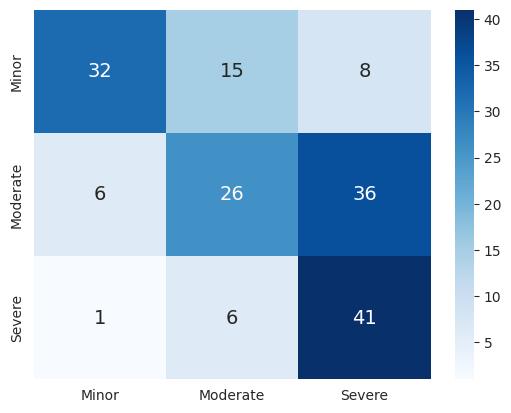

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [ ]:
def severity_estimator(image_path, model):
    print("Determining severity of damage...")
    urllib.request.urlretrieve(image_path, 'save_4th_gate.jpg') # or other way to upload image
    img = load_img('save_4th_gate.jpg', target_size=(256, 256)) # this is a PIL image
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    pred_label = np.argmax(pred, axis=1)
#     print(pred_label)
    d = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for key in d.keys():
        if pred_label[0] == key:
            print("Assessment: {} damage to vehicle".format(d[key]))
    print("Severity assessment complete.")

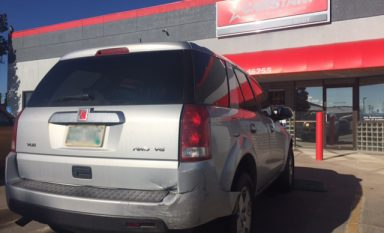

In [ ]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [ ]:
severity_estimator('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Determining severity of damage...
1/1 [==============================] - 1s 720ms/step
Assessment: Minor damage to vehicle
Severity assessment complete.


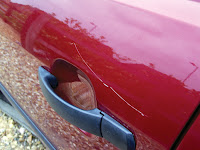

In [ ]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [ ]:
severity_estimator('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

Determining severity of damage...
1/1 [==============================] - 0s 19ms/step
Assessment: Minor damage to vehicle
Severity assessment complete.


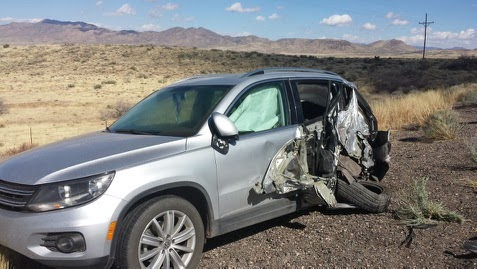

In [ ]:
Image('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg')

In [ ]:
severity_estimator('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg', ft_model)

Determining severity of damage...
1/1 [==============================] - 0s 18ms/step
Assessment: Severe damage to vehicle
Severity assessment complete.


In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import pickle



# Pickle and save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(ft_model, file)


